# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import numpy as np

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [2]:
# Load the model class and some custom functions
import sys
sys.path.append('../')
from models import get_vae_model, get_clustering_vae_model, compute_p, compute_delta
from clustering_metrics import evaluate_model
from draw_embeddings import draw_embeddings, draw_clusters_assignments, compare_reconstructed_images_MNIST

## Load and prepare the MNIST data set

In [3]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct and pretrain the autoencoder

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)

EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
# MOMENTUM = 0.9

model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

# model_vae.encoder.summary()
# model_vae.decoder.summary()

In [5]:
model_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
# model_vae.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM))

model_vae.fit(x_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              verbose=2,
              )

model_vae.save_weights("model_weights/cvae/pretrained/vae")

model_vae.load_weights("model_weights/cvae/pretrained/vae")

Epoch 1/100
469/469 - 3s - total_loss: 37.5671 - reg_loss: 0.4483 - rec_loss: 37.1188 - 3s/epoch - 7ms/step
Epoch 2/100
469/469 - 2s - total_loss: 32.9639 - reg_loss: 0.7229 - rec_loss: 32.2411 - 2s/epoch - 4ms/step
Epoch 3/100
469/469 - 2s - total_loss: 32.0144 - reg_loss: 1.2493 - rec_loss: 30.7652 - 2s/epoch - 4ms/step
Epoch 4/100
469/469 - 2s - total_loss: 31.1594 - reg_loss: 1.8574 - rec_loss: 29.3021 - 2s/epoch - 5ms/step
Epoch 5/100
469/469 - 2s - total_loss: 30.4693 - reg_loss: 2.2128 - rec_loss: 28.2566 - 2s/epoch - 4ms/step
Epoch 6/100
469/469 - 2s - total_loss: 30.0514 - reg_loss: 2.4599 - rec_loss: 27.5915 - 2s/epoch - 4ms/step
Epoch 7/100
469/469 - 2s - total_loss: 29.5954 - reg_loss: 2.8923 - rec_loss: 26.7031 - 2s/epoch - 4ms/step
Epoch 8/100
469/469 - 2s - total_loss: 29.0090 - reg_loss: 3.4063 - rec_loss: 25.6026 - 2s/epoch - 4ms/step
Epoch 9/100
469/469 - 2s - total_loss: 28.5446 - reg_loss: 3.7778 - rec_loss: 24.7667 - 2s/epoch - 4ms/step
Epoch 10/100
469/469 - 2s - 

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


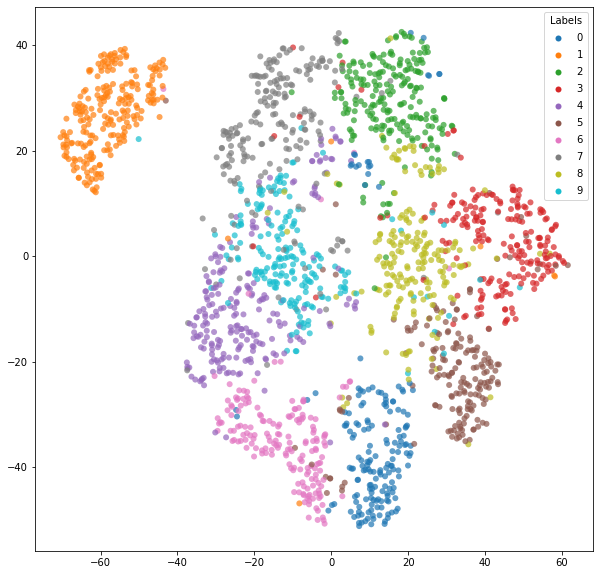

In [6]:
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train)
else:
    z_test = model_vae.encode_only_mu(x_test)
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000], alpha=0.7)

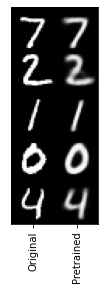

In [7]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, model_vae.encoder, model_vae.decoder, ("Original", "Pretrained"))

# Fine-tune the model (K-Means)

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [8]:
model_vae.load_weights("model_weights/cvae/pretrained/vae")

Construct the VaDE model:

In [9]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 1

EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

model_cvae = get_clustering_vae_model(model_vae, N_CLUSTERS, CLUSTERING_LOSS_WEIGHT)

## Initialize the parameters

Initialize the model parameters from a K-means:

In [10]:
z_train = model_cvae.encode_only_mu(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [11]:
p = compute_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

Evaluate the clustering performance before fine-tunning the model:

In [12]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=kmeans.cluster_centers_)

Acc: 0.563100
ARI: 0.344431
AMI: 0.452036
Sil: 0.118431


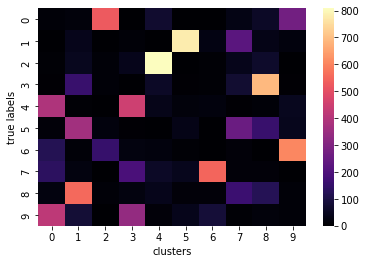

In [13]:
evaluate_model(model_cvae.classify, model_cvae.encode_only_mu, x_test, y_test)

## Train the model

Train the model:

In [14]:
def cvae_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_cvae.soft_assignment(x_train)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_cvae.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=cvae_callback)

In [15]:
model_cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_cvae.fit(x_train, p,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE,
               callbacks = callback,
               verbose=2,
              )

model_cvae.save_weights("model_weights/cvae/finetuned/cvae_kmeans")

model_cvae.load_weights("model_weights/cvae/finetuned/cvae_kmeans")

Epoch 1/100
469/469 - 4s - total_loss: 36.9037 - reg_loss: 6.6944 - rec_loss: 18.9964 - clust_loss: 11.2128 - 4s/epoch - 9ms/step
Epoch 2/100
469/469 - 3s - total_loss: 36.8432 - reg_loss: 6.7104 - rec_loss: 18.9845 - clust_loss: 11.1483 - 3s/epoch - 6ms/step
Epoch 3/100
469/469 - 3s - total_loss: 36.7904 - reg_loss: 6.7364 - rec_loss: 18.9590 - clust_loss: 11.0950 - 3s/epoch - 6ms/step
Epoch 4/100
469/469 - 3s - total_loss: 36.7373 - reg_loss: 6.7580 - rec_loss: 18.9370 - clust_loss: 11.0423 - 3s/epoch - 6ms/step
Epoch 5/100
469/469 - 3s - total_loss: 36.7010 - reg_loss: 6.7700 - rec_loss: 18.9372 - clust_loss: 10.9937 - 3s/epoch - 6ms/step
Epoch 6/100
469/469 - 3s - total_loss: 36.6581 - reg_loss: 6.7975 - rec_loss: 18.9118 - clust_loss: 10.9489 - 3s/epoch - 6ms/step
Epoch 7/100
469/469 - 3s - total_loss: 36.6341 - reg_loss: 6.8389 - rec_loss: 18.8863 - clust_loss: 10.9089 - 3s/epoch - 6ms/step
Epoch 8/100
469/469 - 3s - total_loss: 36.5966 - reg_loss: 6.8578 - rec_loss: 18.8768 - cl

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


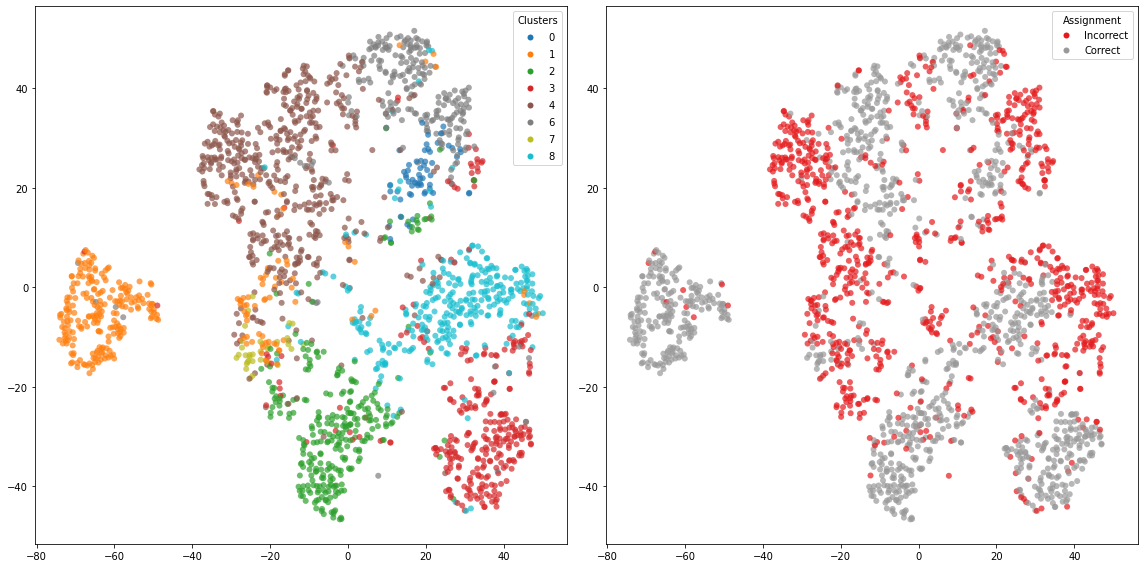

In [16]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

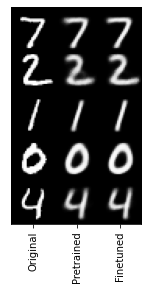

In [17]:
_ = compare_reconstructed_images_MNIST(x_test, model_cvae.encoder, model_cvae.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

Acc: 0.572600
ARI: 0.377826
AMI: 0.495910
Sil: 0.204126


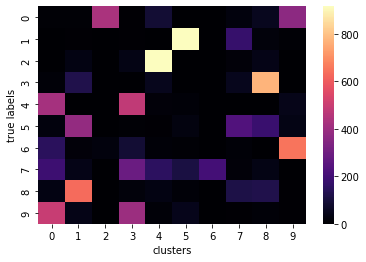

In [18]:
evaluate_model(model_cvae.classify, model_cvae.encode_only_mu, x_test, y_test)

# Fine-tune the model (GMM)

## Construct the model and load the pretrained weights

Load the pretrained weights for the encoder and decoder modules:

In [19]:
model_vae.load_weights("model_weights/cvae/pretrained/vae")

In [20]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 1

EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 1e-5
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

model_cvae = get_clustering_vae_model(model_vae, N_CLUSTERS, CLUSTERING_LOSS_WEIGHT)

## Initialize the parameters

In [21]:
z_train = model_cvae.encode_only_mu(x_train)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')
gmm.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(gmm.means_))

In [22]:
p = compute_p(to_categorical(gmm.predict(z_train)))
c_last = gmm.predict(z_train)

Evaluate the clustering performance before fine-tunning the model:

In [23]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=gmm.means_)

Acc: 0.584300
ARI: 0.353963
AMI: 0.462427
Sil: 0.091265


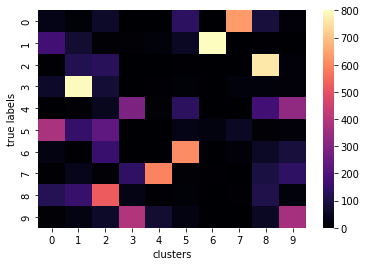

In [24]:
evaluate_model(model_cvae.classify, model_cvae.encode_only_mu, x_test, y_test)

## Train the model

In [25]:
model_cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_cvae.fit(x_train, p,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE,
               callbacks = callback,
               verbose=2,
              )

model_cvae.save_weights("model_weights/cvae/finetuned/cvae_gmm")

model_cvae.load_weights("model_weights/cvae/finetuned/cvae_gmm")

Epoch 1/100
469/469 - 4s - total_loss: 37.0644 - reg_loss: 6.6302 - rec_loss: 18.9149 - clust_loss: 11.5193 - 4s/epoch - 9ms/step
Epoch 2/100
469/469 - 3s - total_loss: 37.0105 - reg_loss: 6.6367 - rec_loss: 18.8729 - clust_loss: 11.5009 - 3s/epoch - 6ms/step
Epoch 3/100
469/469 - 3s - total_loss: 37.0300 - reg_loss: 6.6739 - rec_loss: 18.8662 - clust_loss: 11.4898 - 3s/epoch - 6ms/step
Epoch 4/100
469/469 - 3s - total_loss: 37.0069 - reg_loss: 6.6629 - rec_loss: 18.8585 - clust_loss: 11.4854 - 3s/epoch - 6ms/step
Epoch 5/100
469/469 - 3s - total_loss: 36.9816 - reg_loss: 6.6674 - rec_loss: 18.8375 - clust_loss: 11.4767 - 3s/epoch - 6ms/step
Epoch 6/100
469/469 - 3s - total_loss: 36.9716 - reg_loss: 6.6627 - rec_loss: 18.8361 - clust_loss: 11.4727 - 3s/epoch - 7ms/step
Epoch 7/100
469/469 - 3s - total_loss: 36.9886 - reg_loss: 6.6856 - rec_loss: 18.8356 - clust_loss: 11.4675 - 3s/epoch - 6ms/step
Epoch 8/100
469/469 - 3s - total_loss: 36.9862 - reg_loss: 6.6875 - rec_loss: 18.8361 - cl

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


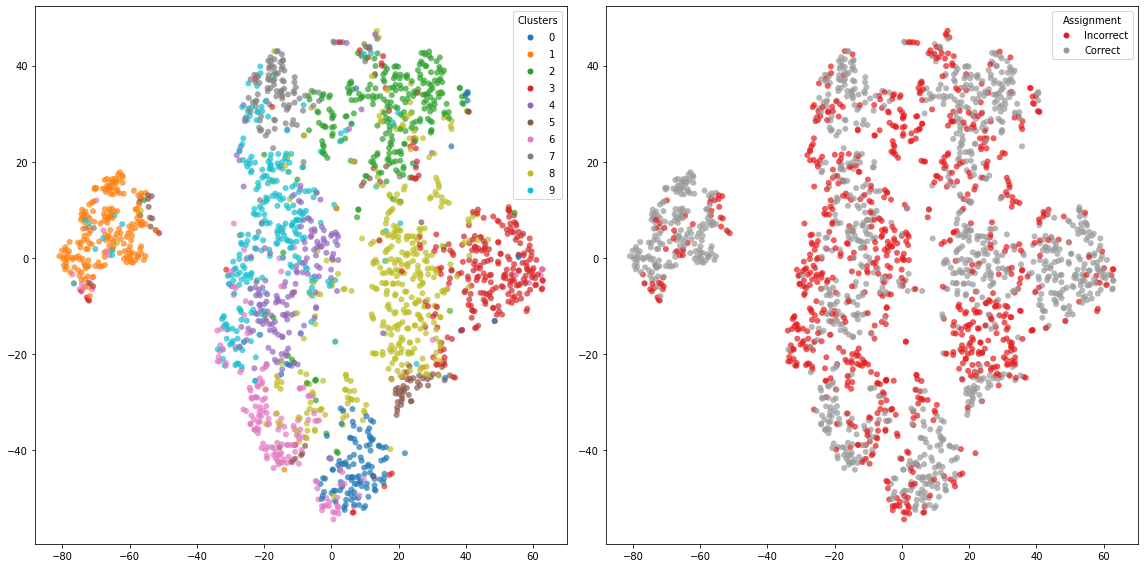

In [26]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

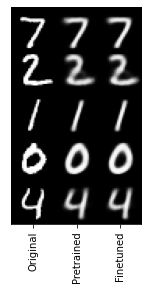

In [27]:
_ = compare_reconstructed_images_MNIST(x_test, model_cvae.encoder, model_cvae.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

Acc: 0.587400
ARI: 0.342110
AMI: 0.473455
Sil: 0.123701


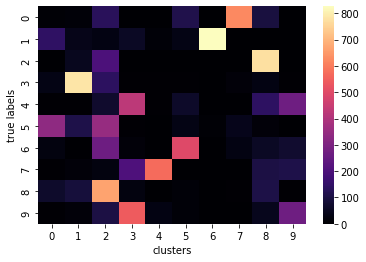

In [28]:
evaluate_model(model_cvae.classify, model_cvae.encode_only_mu, x_test, y_test)